# INSY 669 Text Analytics

### **Group Project: Sentiment Analysis of Toronto Cafes Review on Google Maps**

Mar 1st, 2023


**Group Members:**
1. Ke(Kristen) Chen
2. Shanshan Lao 
3. Xinran(Iris) Liu
4. Yang(Olivia) Ma
5. Duoyi(Flora) Zhang



# Dependencies

In [ ]:
import pandas as pd
import numpy as np

import re
import string
import sys, spacy, logging
from pprint import pprint

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')

from tqdm.notebook import tqdm

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Acquistion

In [ ]:
reviews_df = pd.read_csv("cafes_reviews.csv")
reviews_df.head()

,cafe,street,user,time,stars,reviews
0,Bud's Coffee,Queen St E,David Baker,a week ago,4 stars,NaN
1,Bud's Coffee,Queen St E,Michael Bunga,a week ago,5 stars,NaN
2,Bud's Coffee,Queen St E,Jeffrey Taylor,2 weeks ago,5 stars,Great coffee and fresh baked goods.\nTalking w...
3,Bud's Coffee,Queen St E,Dasong Zou,2 weeks ago,5 stars,I had a great tea here. Very pleasant.
4,Bud's Coffee,Queen St E,Carrie T,4 weeks ago,4 stars,NaN


In [ ]:
reviews_df = reviews_df.dropna().reset_index()
reviews_df = reviews_df.drop(columns='index')

print(reviews_df.info())
reviews_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cafe     2066 non-null   object
 1   street   2066 non-null   object
 2   user     2066 non-null   object
 3   time     2066 non-null   object
 4   stars    2066 non-null   object
 5   reviews  2066 non-null   object
dtypes: object(6)
memory usage: 97.0+ KB
None


,cafe,street,user,time,stars,reviews
0,Bud's Coffee,Queen St E,Jeffrey Taylor,2 weeks ago,5 stars,Great coffee and fresh baked goods.\nTalking w...
1,Bud's Coffee,Queen St E,Dasong Zou,2 weeks ago,5 stars,I had a great tea here. Very pleasant.
2,Bud's Coffee,Queen St E,t s,a month ago,5 stars,My Flat white was superb. It’s a tiny spot wi...
3,Bud's Coffee,Queen St E,Francesca Arkley,2 months ago,5 stars,Best coffee and lemonade and chai lattes! Bud'...
4,Bud's Coffee,Queen St E,Sean Persad,3 months ago,5 stars,Like the sidewalk ordering window. The America...
5,Bud's Coffee,Queen St E,littleyirkie,3 months ago,3 stars,Love coffee n service but line blocks sidewalk...
6,Bud's Coffee,Queen St E,Vivian Tao,4 months ago,5 stars,Amazing breakfast sandwiches !
7,Bud's Coffee,Queen St E,Mourad Mrabet,4 months ago,5 stars,Small shop (squeezed between two restaurants) ...
8,Bud's Coffee,Queen St E,chris monster,4 months ago,5 stars,"Great cortado, accepts reusable cups - or enj..."
9,Bud's Coffee,Queen St E,Rizal,5 months ago,4 stars,Nice line up of wholebeans by Quietly and Hatc...


In [ ]:
reviews_df.nunique()

cafe         12
street        2
user       1949
time         34
stars         5
reviews    2048
dtype: int64

There is no actual feature can be seen as a unique identifier, we can only use index as a uid.

# Data Cleaning

In [ ]:
df = reviews_df.copy()

Convert stars to numerical value

In [ ]:
df['stars'] = [int(s.split(' ')[1]) for s in df['stars']]
df.head()

,cafe,street,user,time,stars,reviews
0,Bud's Coffee,Queen St E,Jeffrey Taylor,2 weeks ago,5,Great coffee and fresh baked goods.\nTalking w...
1,Bud's Coffee,Queen St E,Dasong Zou,2 weeks ago,5,I had a great tea here. Very pleasant.
2,Bud's Coffee,Queen St E,t s,a month ago,5,My Flat white was superb. It’s a tiny spot wi...
3,Bud's Coffee,Queen St E,Francesca Arkley,2 months ago,5,Best coffee and lemonade and chai lattes! Bud'...
4,Bud's Coffee,Queen St E,Sean Persad,3 months ago,5,Like the sidewalk ordering window. The America...


Add Sentiment Labels

In [ ]:
df['sentiment'] = ["neg" if s<3 else "pos" if s>3 else "neu" for s in df['stars']]

#verify
df[df['stars'] == 2]

,cafe,street,user,time,stars,reviews,sentiment
121,Bud's Coffee,Queen St E,Milena Samra,4 years ago,2,"Hey, if you're looking to pay almost $5 for an...",neg
212,Juice & Java Cafe,Queen St E,Vivienne McCuaig,3 years ago,2,The location is great and the food and coffee ...,neg
220,Juice & Java Cafe,Queen St E,Angela Arnold,3 years ago,2,Overpriced! Same food you can make at home wit...,neg
226,Juice & Java Cafe,Queen St E,Van Nguyen,3 years ago,2,Long wait time and not as described.\n\nI orde...,neg
234,Juice & Java Cafe,Queen St E,Lorraine Syratt,3 years ago,2,Two stars for effort. Gave us the wrong order...,neg
...,...,...,...,...,...,...,...
1837,Coffee Island,Bay St,Joe Korkis,5 years ago,2,Too expensive,neg
1850,Coffee Island,Bay St,Cindy Basha,5 years ago,2,My big problem with this coffee shop is well.....,neg
1878,White Rabbit Caffe,Bay St,Ramya Gudipudi,7 months ago,2,Ordered oat latte but had weird after taste fo...,neg
1908,White Rabbit Caffe,Bay St,Timothy K,a year ago,2,"The White Rabb was really missing ""it"" (see ph...",neg


Check if the reviews are English

In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 32.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=cbce08c1816b324f9e50915089ad907c3f580a4a85a47e41a07aae16de182560
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [ ]:
from langdetect import detect_langs, LangDetectException

languages = []
for review in df['reviews']:
    try:
        lang_list = detect_langs(review)
        lang_str = str(lang_list[0]).split(':')[0]
    except LangDetectException:
        lang_str = 'unknown'
    languages.append(lang_str)

df['language'] = languages
df.head()

,cafe,street,user,time,stars,reviews,sentiment,language
0,Bud's Coffee,Queen St E,Jeffrey Taylor,2 weeks ago,5,Great coffee and fresh baked goods.\nTalking w...,pos,en
1,Bud's Coffee,Queen St E,Dasong Zou,2 weeks ago,5,I had a great tea here. Very pleasant.,pos,en
2,Bud's Coffee,Queen St E,t s,a month ago,5,My Flat white was superb. It’s a tiny spot wi...,pos,en
3,Bud's Coffee,Queen St E,Francesca Arkley,2 months ago,5,Best coffee and lemonade and chai lattes! Bud'...,pos,en
4,Bud's Coffee,Queen St E,Sean Persad,3 months ago,5,Like the sidewalk ordering window. The America...,pos,en


*Basic Cleaning*
1. lowercase
2. punctuation removal
3. white space removal
4. speical characters removal
5. tokenization

*Text Filtering*
1. stop words removal
2. text normalization (lemmatization)
3. text filtering: noun, adj, verb, adv (optional)
4. filter non-english reviews

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['get', 'go','always','back','would','also','one','and',
                    'go', 'get', 'do',  'also', 'may'])
print(len(stop_words))

# Extend stop words from spacy library
sw_spacy = spacy.load('en_core_web_sm').Defaults.stop_words
stop_words.extend(sw_spacy)
print(len(stop_words))

allowed_postags = ['NOUN','ADJ', 'VERB', 'ADV']

192
518


In [ ]:
def text_cleaning(sentence):
    # Remove punctuation with white space (to avoid concatenation)
    result = sentence.translate(str.maketrans(string.punctuation," "*len(string.punctuation))) 

    # replace multiple spaces with simple space
    result = re.sub(' +', ' ', result) 

    # remove special characters
    #result = result.str.replace('[^A-Za-z0-9]+', ' ')

    # Converts a document into a list of lowercase tokens
    # ignoring tokens that are too long or too short
    result = gensim.utils.simple_preprocess(str(result), deacc=True) 
    #yield(result)

    # Remove stop words -----
    text = [word for word in result if word not in stop_words]

    # Initialize the output text list
    text_out = []

    # Load the small English model, disable the parser and NER components
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    doc = nlp(" ".join(text)) # join all strings together

    # Text normalization: lemma_ returns the base form of the word
    text_out.append([token.lemma_ for token in doc])
    
    # Text filtering: keep only words that have a POS tag in allowed_postags
    # text_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    return text_out[0]

In [ ]:
df['tokenized'] = [text_cleaning(w) for w in df['reviews']]
df['tokenized'].head()

In [ ]:
df['cleaned_text'] =  [' '.join(map(str, s)) for s in df['tokenized']]
df['cleaned_text'].head()

In [ ]:
df.head()

In [ ]:
df.to_csv('cleaned_reviews.csv')

# YOU CAN START FROM HERE TO AVOID LONG RUNTIME 

In [ ]:
df = pd.read_csv('cleaned_reviews.csv')
df = df.rename(columns={ df.columns[0]: "index" })
df.head()

,index,cafe,street,user,time,stars,reviews,sentiment,language,tokenized,cleaned_text
0,0,Bud's Coffee,Queen St E,Jeffrey Taylor,2 weeks ago,5,Great coffee and fresh baked goods.\nTalking w...,pos,en,"['great', 'coffee', 'fresh', 'baked', 'good', ...",great coffee fresh baked good talk sarah day love
1,1,Bud's Coffee,Queen St E,Dasong Zou,2 weeks ago,5,I had a great tea here. Very pleasant.,pos,en,"['great', 'tea', 'pleasant']",great tea pleasant
2,2,Bud's Coffee,Queen St E,t s,a month ago,5,My Flat white was superb. It’s a tiny spot wi...,pos,en,"['flat', 'white', 'superb', 'tiny', 'spot', 'l...",flat white superb tiny spot limited seat clean...
3,3,Bud's Coffee,Queen St E,Francesca Arkley,2 months ago,5,Best coffee and lemonade and chai lattes! Bud'...,pos,en,"['good', 'coffee', 'lemonade', 'chai', 'latte'...",good coffee lemonade chai latte bud delicious ...
4,4,Bud's Coffee,Queen St E,Sean Persad,3 months ago,5,Like the sidewalk ordering window. The America...,pos,en,"['like', 'sidewalk', 'ordering', 'window', 'am...",like sidewalk ordering window americano good


# Model Building

In [ ]:
model= SentimentIntensityAnalyzer()
model

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['reviews']
    myid = row['index']
    res[myid] = model.polarity_scores(text)

# Keeping the results as Dataframe
Vader_res = pd.DataFrame(res).T
Vader_res

  0%|          | 0/2066 [00:00<?, ?it/s]

,neg,neu,pos,compound
0,0.146,0.564,0.290,0.5145
1,0.000,0.342,0.658,0.8268
2,0.040,0.500,0.460,0.9572
3,0.087,0.591,0.323,0.7901
4,0.000,0.516,0.484,0.7579
...,...,...,...,...
2061,0.017,0.749,0.234,0.9686
2062,0.000,0.185,0.815,0.6588
2063,0.045,0.929,0.026,-0.0852
2064,0.039,0.634,0.328,0.9582


In [ ]:
Vader_res = pd.merge(df, Vader_res, left_index=True, right_index=True).drop(columns='index')
Vader_res

,cafe,street,user,time,stars,reviews,sentiment,language,tokenized,cleaned_text,neg,neu,pos,compound
0,Bud's Coffee,Queen St E,Jeffrey Taylor,2 weeks ago,5,Great coffee and fresh baked goods.\nTalking w...,pos,en,"['great', 'coffee', 'fresh', 'baked', 'good', ...",great coffee fresh baked good talk sarah day love,0.146,0.564,0.290,0.5145
1,Bud's Coffee,Queen St E,Dasong Zou,2 weeks ago,5,I had a great tea here. Very pleasant.,pos,en,"['great', 'tea', 'pleasant']",great tea pleasant,0.000,0.342,0.658,0.8268
2,Bud's Coffee,Queen St E,t s,a month ago,5,My Flat white was superb. It’s a tiny spot wi...,pos,en,"['flat', 'white', 'superb', 'tiny', 'spot', 'l...",flat white superb tiny spot limited seat clean...,0.040,0.500,0.460,0.9572
3,Bud's Coffee,Queen St E,Francesca Arkley,2 months ago,5,Best coffee and lemonade and chai lattes! Bud'...,pos,en,"['good', 'coffee', 'lemonade', 'chai', 'latte'...",good coffee lemonade chai latte bud delicious ...,0.087,0.591,0.323,0.7901
4,Bud's Coffee,Queen St E,Sean Persad,3 months ago,5,Like the sidewalk ordering window. The America...,pos,en,"['like', 'sidewalk', 'ordering', 'window', 'am...",like sidewalk ordering window americano good,0.000,0.516,0.484,0.7579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,Dispatch Coffee,Bay St,Benny Tong,a year ago,4,"Too early to close, really hard for the people...",pos,en,"['early', 'close', 'hard', 'people', 'enjoy', ...",early close hard people enjoy cup coffee work ...,0.017,0.749,0.234,0.9686
2062,Dispatch Coffee,Bay St,Gabriel Lessard,a year ago,5,Great coffee!,pos,en,"['great', 'coffee']",great coffee,0.000,0.185,0.815,0.6588
2063,Dispatch Coffee,Bay St,G,a year ago,1,"It costs 3.50 for a their large size cup, whic...",neg,en,"['cost', 'large', 'size', 'cup', 'small', 'med...",cost large size cup small medium standard flav...,0.045,0.929,0.026,-0.0852
2064,Dispatch Coffee,Bay St,N'Gatta Aka,a year ago,5,I am a long time subscriber of their monthly d...,pos,en,"['long', 'time', 'subscriber', 'monthly', 'del...",long time subscriber monthly delivery plan exc...,0.039,0.634,0.328,0.9582


In [ ]:
# Reading the most positive review
a = Vader_res['compound'].idxmax()
max_row = Vader_res.loc[a]
print(max_row)
max_review = Vader_res.loc[a, 'reviews']
print(max_review)

cafe                                             Remarkable Beans
street                                                 Queen St E
user                                              Sydney Westgate
time                                                  4 years ago
stars                                                           5
reviews         My family and I are frequent customers at the ...
sentiment                                                     pos
language                                                       en
tokenized       ['family', 'frequent', 'customer', 'bean', 'le...
cleaned_text    family frequent customer bean leslieville beac...
neg                                                         0.012
neu                                                         0.708
pos                                                          0.28
compound                                                   0.9991
Name: 849, dtype: object
My family and I are frequent customers at the Bean 

In [ ]:
# Define a function to create labels based on compound score, 0.5? or other number
def Sentiment_label(value):
    if value > 0:
        return "Positive"
    if value == 0:
        return "Neutral"
    if value < 0:
        return "Negative"
     
Vader_res["Review_Sentiment"] = Vader_res['compound'].map(Sentiment_label)

In [ ]:
Vader_res

,cafe,street,user,time,stars,reviews,sentiment,language,tokenized,cleaned_text,neg,neu,pos,compound,Review_Sentiment
0,Bud's Coffee,Queen St E,Jeffrey Taylor,2 weeks ago,5,Great coffee and fresh baked goods.\nTalking w...,pos,en,"['great', 'coffee', 'fresh', 'baked', 'good', ...",great coffee fresh baked good talk sarah day love,0.146,0.564,0.290,0.5145,Positive
1,Bud's Coffee,Queen St E,Dasong Zou,2 weeks ago,5,I had a great tea here. Very pleasant.,pos,en,"['great', 'tea', 'pleasant']",great tea pleasant,0.000,0.342,0.658,0.8268,Positive
2,Bud's Coffee,Queen St E,t s,a month ago,5,My Flat white was superb. It’s a tiny spot wi...,pos,en,"['flat', 'white', 'superb', 'tiny', 'spot', 'l...",flat white superb tiny spot limited seat clean...,0.040,0.500,0.460,0.9572,Positive
3,Bud's Coffee,Queen St E,Francesca Arkley,2 months ago,5,Best coffee and lemonade and chai lattes! Bud'...,pos,en,"['good', 'coffee', 'lemonade', 'chai', 'latte'...",good coffee lemonade chai latte bud delicious ...,0.087,0.591,0.323,0.7901,Positive
4,Bud's Coffee,Queen St E,Sean Persad,3 months ago,5,Like the sidewalk ordering window. The America...,pos,en,"['like', 'sidewalk', 'ordering', 'window', 'am...",like sidewalk ordering window americano good,0.000,0.516,0.484,0.7579,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,Dispatch Coffee,Bay St,Benny Tong,a year ago,4,"Too early to close, really hard for the people...",pos,en,"['early', 'close', 'hard', 'people', 'enjoy', ...",early close hard people enjoy cup coffee work ...,0.017,0.749,0.234,0.9686,Positive
2062,Dispatch Coffee,Bay St,Gabriel Lessard,a year ago,5,Great coffee!,pos,en,"['great', 'coffee']",great coffee,0.000,0.185,0.815,0.6588,Positive
2063,Dispatch Coffee,Bay St,G,a year ago,1,"It costs 3.50 for a their large size cup, whic...",neg,en,"['cost', 'large', 'size', 'cup', 'small', 'med...",cost large size cup small medium standard flav...,0.045,0.929,0.026,-0.0852,Negative
2064,Dispatch Coffee,Bay St,N'Gatta Aka,a year ago,5,I am a long time subscriber of their monthly d...,pos,en,"['long', 'time', 'subscriber', 'monthly', 'del...",long time subscriber monthly delivery plan exc...,0.039,0.634,0.328,0.9582,Positive


Text(0, 0.5, 'Number of Reviews')

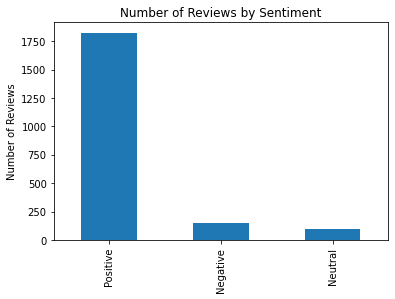

In [ ]:
ax = Vader_res.Review_Sentiment.value_counts().plot(kind = 'bar', label = 'ax')
ax.set_title ("Number of Reviews by Sentiment")
ax.set_ylabel ("Number of Reviews")

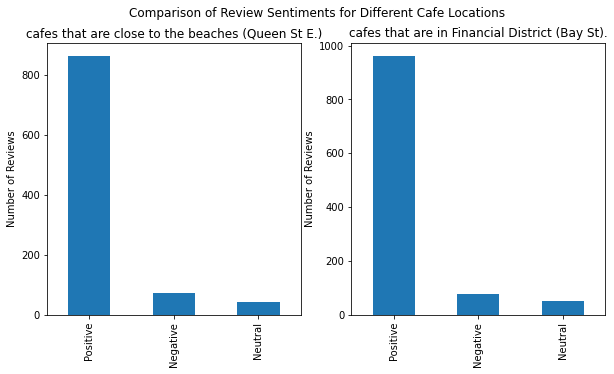

In [ ]:
# Define the desired cafe names for both groups
cafe_names1 = ["Bud's Coffee", 'Juice & Java Cafe', 'The Beacher Cafe', "Simple Coffee", "Remarkable Beans","The Haven Low-Carb Cafe"]
cafe_names2 = ["Dineen Coffee Co.", 'Mos Mos Coffee', 'NEO COFFEE BAR', "Coffee Island", "White Rabbit Caffe","Dispatch Coffee"]

# Filter the Vader_res dataframe based on the cafe names for each group
filtered_df1 = Vader_res[Vader_res['cafe'].isin(cafe_names1)]
filtered_df2 = Vader_res[Vader_res['cafe'].isin(cafe_names2)]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

filtered_df1['Review_Sentiment'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title("cafes that are close to the beaches (Queen St E.)")
ax1.set_ylabel("Number of Reviews")

filtered_df2['Review_Sentiment'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("cafes that are in Financial District (Bay St).")
ax2.set_ylabel("Number of Reviews")

fig.suptitle('Comparison of Review Sentiments for Different Cafe Locations')

plt.show()

In [ ]:
# Create 3 subsets 
Positive_reviews = Vader_res[Vader_res['Review_Sentiment'] == 'Positive']
#Neutral_reviews = Vader_res[Vader_res['Review_Sentiment'] == 'Neutral']
Negative_reviews = Vader_res[Vader_res['Review_Sentiment'] == 'Negative']

In [ ]:
# Combine each tweets to for the 3 subsets 

combined_pos_reviews =  ''.join(Positive_reviews.reviews)
print("There are {} words in the combination of all positive tweets.\n".format(len(combined_pos_reviews)))

#combined_neu_reviews =  ''.join(Neutral_reviews.reviews)
#print("There are {} words in the combination of all neutral tweets.\n" .format(len(combined_neu_reviews)))

combined_neg_reviews =  ''.join(Negative_reviews.reviews)
print("There are {} words in the combination of all negative tweets.\n" .format(len(combined_neg_reviews)))

There are 292171 words in the combination of all positive tweets.

There are 39344 words in the combination of all negative tweets.



In [ ]:
Negative_reviews

,cafe,street,user,time,stars,reviews,sentiment,language,tokenized,cleaned_text,neg,neu,pos,compound,Review_Sentiment
5,Bud's Coffee,Queen St E,littleyirkie,3 months ago,3,Love coffee n service but line blocks sidewalk...,neu,en,"['love', 'coffee', 'service', 'line', 'block',...",love coffee service line block sidewalk proble...,0.313,0.556,0.131,-0.5562,Negative
13,Bud's Coffee,Queen St E,Jenn C,8 months ago,5,My #1 spot for coffee and snacks in the beache...,pos,en,"['spot', 'coffee', 'snack', 'beach', 'go', 'co...",spot coffee snack beach go countless time disa...,0.104,0.824,0.073,-0.2746,Negative
24,Bud's Coffee,Queen St E,Jessica Darling,a year ago,5,Great spot! Coffee is great and the vegan bana...,pos,en,"['great', 'spot', 'coffee', 'great', 'vegan', ...",great spot coffee great vegan banana walnut mu...,0.151,0.636,0.213,-0.0924,Negative
32,Bud's Coffee,Queen St E,K K,a year ago,3,Cute walk up coffee spot in the Beaches. The d...,neu,en,"['cute', 'walk', 'coffee', 'spot', 'beach', 'd...",cute walk coffee spot beach downside patio sea...,0.076,0.870,0.054,-0.0516,Negative
52,Bud's Coffee,Queen St E,Michal Wachsmann,2 years ago,1,"Ordered a cappuccino, unfriendly service by th...",neg,en,"['order', 'cappuccino', 'unfriendly', 'service...",order cappuccino unfriendly service young man ...,0.116,0.884,0.000,-0.3612,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954,White Rabbit Caffe,Bay St,Shane Anne Sabarillo,2 years ago,5,The blueberry earl gray croissant is to die fo...,pos,en,"['blueberry', 'earl', 'gray', 'croissant', 'di...",blueberry earl gray croissant die def recommend,0.267,0.574,0.159,-0.4003,Negative
1955,White Rabbit Caffe,Bay St,John Q,2 years ago,3,Staff is 5 🌟 but they use a horrible machine t...,neu,en,"['staff', 'use', 'horrible', 'machine', 'pull'...",staff use horrible machine pull shot make espr...,0.155,0.719,0.126,-0.2263,Negative
1968,White Rabbit Caffe,Bay St,Toby Whitfield,2 years ago,3,"Great coffee, but yikes for COVID risk. This p...",neu,en,"['great', 'coffee', 'yike', 'covid', 'risk', '...",great coffee yike covid risk place tiny table ...,0.210,0.697,0.093,-0.7257,Negative
2038,Dispatch Coffee,Bay St,More Spinach,4 months ago,1,No way is this a 4.7 in terms of actual coffee...,neg,en,"['way', 'term', 'actual', 'coffee', 'beautiful...",way term actual coffee beautiful shop great lo...,0.079,0.831,0.090,-0.0772,Negative


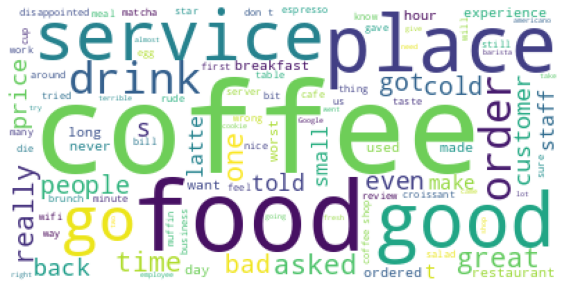

In [ ]:
# Create word cloud for negative tweets
stopwords = set(STOPWORDS)
word_cloud = WordCloud(background_color = 'white', 
                       stopwords = stopwords, 
                       max_words = 100).generate(combined_neg_reviews)


plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout()
 
plt.show()

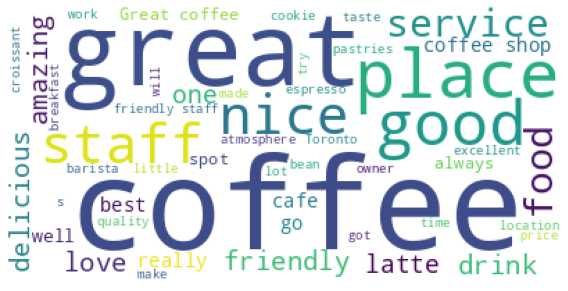

In [ ]:
# Create word cloud for positive tweets
word_cloud = WordCloud(background_color = 'white', 
                       stopwords = stopwords, 
                       max_words = 50).generate(combined_pos_reviews)


plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout()
 
plt.show()

## Negative and Postive Reviews by Location

In [ ]:
Positive_reviews_queen=Positive_reviews[Positive_reviews['street']=="Queen St E"]
combined_pos_reviews_queen =  ''.join(Positive_reviews_queen.reviews)
print("There are {} words in the combination of all postive tweets in Queen Street East.\n".format(len(combined_pos_reviews_queen)))

There are 118775 words in the combination of all postive tweets in Queen Street East.



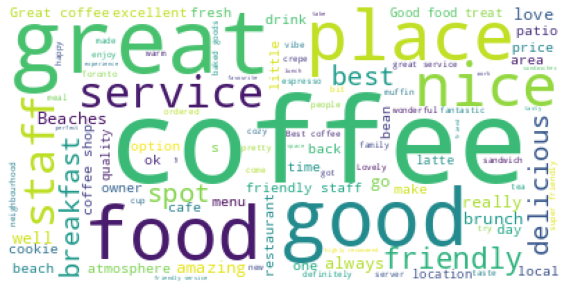

In [ ]:
# Create word cloud for positive tweets
stopwords = set(STOPWORDS)
word_cloud = WordCloud(background_color = 'white', 
                       stopwords = stopwords, 
                       max_words = 100).generate(combined_pos_reviews_queen)


plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout()
 
plt.show()

In [ ]:
Negative_reviews_queen=Negative_reviews[Negative_reviews['street']=="Queen St E"]
combined_neg_reviews_queen =  ''.join(Negative_reviews_queen.reviews)
print("There are {} words in the combination of all negative tweets in Queen Street East.\n".format(len(combined_neg_reviews_queen)))

There are 21746 words in the combination of all negative tweets in Queen Street East.



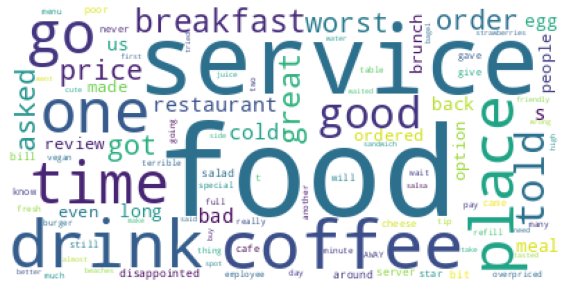

In [ ]:
# Create word cloud for negative tweets
stopwords = set(STOPWORDS)
word_cloud = WordCloud(background_color = 'white', 
                       stopwords = stopwords, 
                       max_words = 100).generate(combined_neg_reviews_queen)


plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout()
 
plt.show()

In [ ]:
Positive_reviews_bay=Positive_reviews[Positive_reviews['street']=="Bay St"]
combined_pos_reviews_bay =  ''.join(Positive_reviews_bay.reviews)
print("There are {} words in the combination of all postive tweets in Bay Street.\n".format(len(combined_pos_reviews_bay)))

There are 173396 words in the combination of all postive tweets in Bay Street.



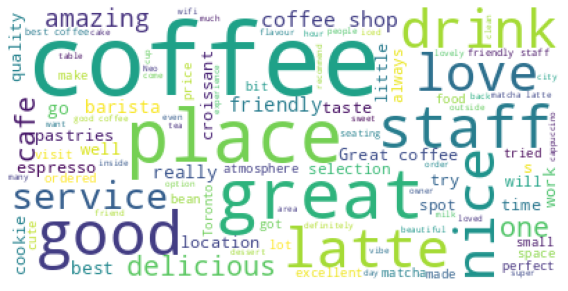

In [ ]:
# Create word cloud for positive tweets
stopwords = set(STOPWORDS)
word_cloud = WordCloud(background_color = 'white', 
                       stopwords = stopwords, 
                       max_words = 100).generate(combined_pos_reviews_bay)


plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout()
 
plt.show()

In [ ]:
Negative_reviews_bay=Negative_reviews[Negative_reviews['street']=="Bay St"]
combined_neg_reviews_bay =  ''.join(Negative_reviews_bay.reviews)
print("There are {} words in the combination of all negative tweets in Bay Street.\n".format(len(combined_neg_reviews_bay)))

There are 17598 words in the combination of all negative tweets in Bay Street.



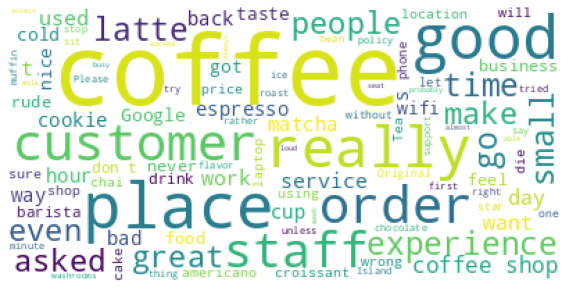

In [ ]:
# Create word cloud for negative tweets
stopwords = set(STOPWORDS)
word_cloud = WordCloud(background_color = 'white', 
                       stopwords = stopwords, 
                       max_words = 100).generate(combined_neg_reviews_bay)


plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout()
 
plt.show()

use the Word2Vec model and see what the words are most likely around our target words such as coffee,service etc.

In [ ]:
df_good = df[df['stars']>=4]

In [ ]:
df_good

In [ ]:
from gensim.models import Word2Vec

# Load preprocessed review data
sentences = df_good['tokenized'].apply(lambda x: x.split())

# Train Word2Vec model
model = Word2Vec(sentences=sentences, size=500, window=10, min_count=1, workers=4, sg=0)

# Print results
model.predict_output_word(["'coffee',"], topn=10)




In [ ]:
from gensim.models import Word2Vec

# Load preprocessed review data
sentences = df_good['tokenized'].apply(lambda x: x.split())

# Train Word2Vec model
model = Word2Vec(sentences=sentences, size=500, window=10, min_count=1, workers=4, sg=0)

# Print results
model.predict_output_word(["'service',"], topn=10)

In [ ]:
from gensim.models import Word2Vec

# Load preprocessed review data
sentences = df_good['tokenized'].apply(lambda x: x.split())

# Train Word2Vec model
model = Word2Vec(sentences=sentences, size=500, window=10, min_count=1, workers=4, sg=0)

# Print results
model.predict_output_word(["'food',"], topn=10)


# Supervised Learning Classifiers


We can also use historical data with known sentiment to predict the sentiment of a new piece of text. Here I will use two supervised learning classifiers: logistic regression and naive bayes.
First, I labeled the positive reviews as “1” (with rating of four or five) and negative reviews as “0” (with rating of one or two). 84.66% of recies are positive

In [ ]:
# Create new column to indicate positive/negative sentiment based on star rating
df['label'] = df['sentiment'].apply(lambda x: 1 if x=='pos' else 0)

# Print percentage of positive reviews
positive_percent = df['label'].mean() * 100
print(f"Percentage of positive reviews: {positive_percent:.2f}%")

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# vectorization
vect = CountVectorizer(max_features=300)
vect.fit(df.tokenized)
X = vect.transform(df.tokenized)
X_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
# Define the vector of targets and matrix of features
y = df.label
X = X_df
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred_lg = log_reg.predict(X_test)
# find the most informative words
log_odds = log_reg.coef_[0]
coeff = pd.DataFrame(log_odds, X.columns, columns=['coef'])\
            .sort_values(by='coef', ascending=False)

In [ ]:
coeff

We could see the most infomative words for positive reviews are: amazing, downtown,delicious,awesome,friendly

And the most infomative words for negative reviews are: server,overprice,use,salad and bad.

The second model is Naive Bayes.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
pred = nb_classifier.predict(X_test)

Cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# define the models
log_reg = LogisticRegression()
nb_classifier = MultinomialNB()

# define the cross-validation procedure
kfold = KFold(n_splits=10, shuffle=True, random_state=100)

# evaluate the models using cross-validation
log_reg_scores = cross_val_score(log_reg, X, y, scoring='accuracy', cv=kfold)
nb_scores = cross_val_score(nb_classifier, X, y, scoring='accuracy', cv=kfold)

# report the mean accuracy and standard deviation for each model
print('Logistic Regression Accuracy: %.3f (%.3f)' % (np.mean(log_reg_scores), np.std(log_reg_scores)))
print('Naive Bayes Accuracy: %.3f (%.3f)' % (np.mean(nb_scores), np.std(nb_scores)))
